In [6]:
import cartopy.crs as ccrs
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer
import pystac_client
import xarray as xr

In [7]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# https://planetarycomputer.microsoft.com/api/sas/v1/token/sentinel-5p-l2-netcdf

# https://naipeuwest.blob.core.windows.net/naip/01.tif?st=2023-09-09T13%3A06%3A30Z&se=2023-09-10T13%3A51%3A30Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-09-10T04%3A26%3A48Z&ske=2023-09-17T04%3A26%3A48Z&sks=b&skv=2021-06-08&sig=hYZYdHv/nP1qi0eS%2BYBjm6/QN5CoL3vx5dT8PoCKVQg%3D

# https://sentinel5euwest.blob.core.windows.net/sentinel-5p/L2__CH4___

In [8]:
longitude = 79.109
latitude = 22.746

geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2023-04-02/2023-04-03",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "o3"}},
)
items = list(search.items())

print(f"Found {len(items)} items:")
print(items)


Found 2 items:
[<Item id=S5P_L2_O3_____20230403T063304_20230403T081434_28345>, <Item id=S5P_L2_O3_____20230402T065156_20230402T083327_28331>]


In [13]:
f = fsspec.open(items[0].assets["o3"].href).open()
ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")
# ds = xr.open_dataset(f)

ds

<xarray.Dataset>
Dimensions:                                (scanline: 4173, ground_pixel: 450,
                                            time: 1, corner: 4, layer: 14,
                                            level: 15)
Coordinates:
  * scanline                               (scanline) float64 0.0 ... 4.172e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * time                                   (time) datetime64[ns] 2023-04-03
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) int32 0 1 2 3 ... 10 11 12 13
  * level                                  (level) int32 0 1 2 3 ... 11 12 13 14
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (time, scanline) object ...
    qa_value                               (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...

In [15]:
varname = "formaldehyde_tropospheric_vertical_column"
data = ds[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])
data.plot(vmin=vmin, vmax=vmax, cmap="Spectral");

KeyError: 'formaldehyde_tropospheric_vertical_column'

/srv/conda/envs/notebook/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


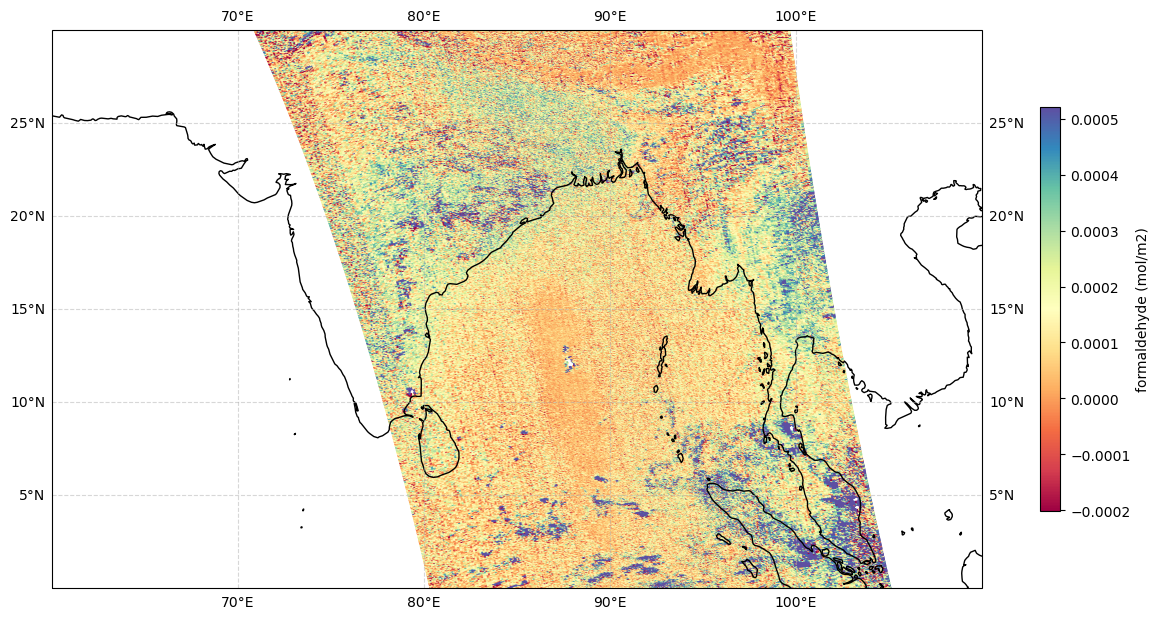

In [ ]:
# formaldehyde product (NaN locations are transparent)
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
formaldehyde = data.values

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
# ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_extent([60, 110, 0, 30], crs=ccrs.PlateCarree())

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scatter = plt.scatter(
    lon,
    lat,
    c=formaldehyde,
    transform=ccrs.PlateCarree(),
    cmap="Spectral",
    norm=norm,
    marker="o",
    s=1,
)
fig.colorbar(scatter, pad=0.05, shrink=0.35, label="formaldehyde (mol/m2)")
plt.show()

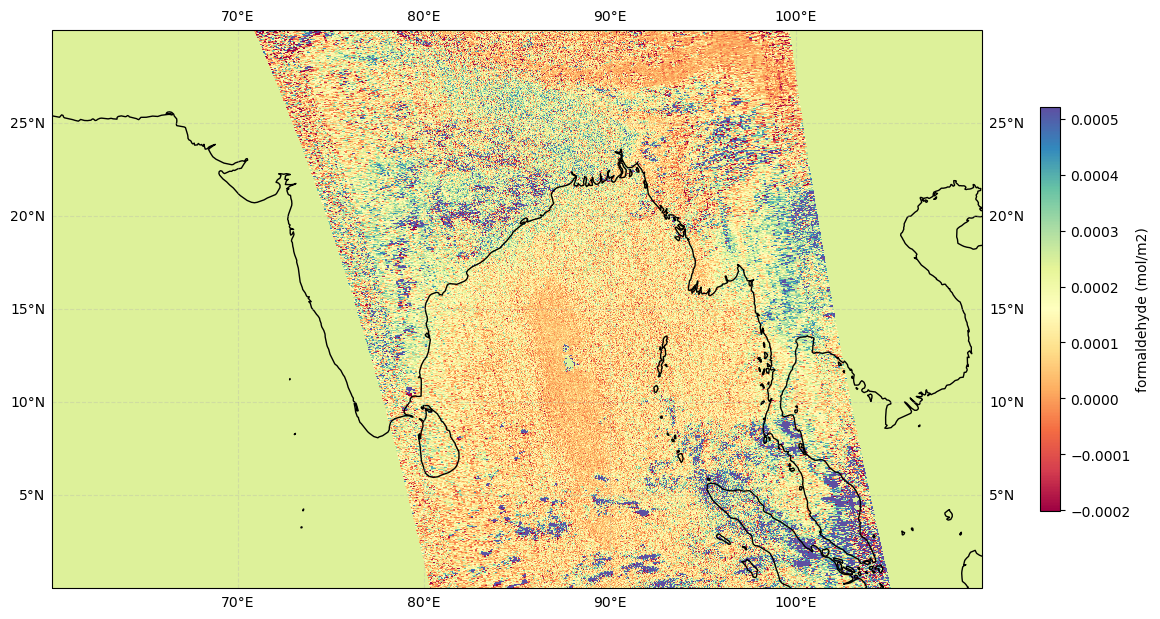

In [ ]:
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.3, linestyle="--")
# ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_extent([60, 110, 0, 30], crs=ccrs.PlateCarree())


colormesh = ax.pcolormesh (lon, lat, formaldehyde, cmap = "Spectral", norm = norm)
fig.colorbar(colormesh, pad=0.05, shrink=0.35, label="formaldehyde (mol/m2)")
